In [1]:
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed, parallel_backend, parallel
import pandas as pd

from change_v_a_and_bound_utils import psiam_tied_data_gen_wrapper_bound_and_v_a_change

# params

In [2]:
V_A = 1.1
theta_A = 1.8

rate_lambda = 0.14
T_0 = 0.66 * (1e-3)
theta_E = 40.5

t_A_aff = 0.03
t_E_aff = 0.05
t_motor = 0.03

Z_E = 0
L = 0.5

N_sim = int(100e3)
dt = 1e-4

N_print = int(100e3/10)
N_params = 10

bound_step_size = 0.5
new_V_A = 1.4

# abl,ild,stim,led times

In [3]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

t_stim_and_led_tuple = [(row['intended_fix'], row['LED_onset_time']) for _, row in df.iterrows()]

ABL_arr = df['ABL'].unique()
ABL_arr.sort()

ILD_arr = df['ILD'].unique()
ILD_arr.sort()

# percentage of LED on trials
frac_of_led = df['LED_trial'].values.sum() / df['LED_trial'].values.size
print(f'frac_of_led: {frac_of_led}')

frac_of_led: 0.33939811074203746


# simulate

In [5]:
bound_change_results_dict = {}
for i in range(N_params):
    new_bound = theta_E - i * bound_step_size

    with parallel_backend('threading', n_jobs=128):
        sim_results = Parallel()(
            delayed(psiam_tied_data_gen_wrapper_bound_and_v_a_change)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E,\
                                                               t_A_aff, t_E_aff, t_motor, L,t_stim_and_led_tuple, new_bound, new_V_A, iter_num, \
                                                                N_print, dt)
            for iter_num in range(N_sim)
        )

    print(f'V_A: {V_A}, new bound: {new_bound}, ')

    bound_change_results_dict[i] = {'results': sim_results, 'new_bound':  new_bound, 'new_V_A': new_V_A }

os id: 40613, In iter_num: 0, ABL: 40, ILD: -1.0, t_stim: 0.352402289461161
os id: 40613, In iter_num: 10000, ABL: 40, ILD: 8.0, t_stim: 0.218573144352728
os id: 40613, In iter_num: 20000, ABL: 40, ILD: -2.0, t_stim: 1.39750055780088
os id: 40613, In iter_num: 30000, ABL: 20, ILD: -2.0, t_stim: 0.747994636742225
os id: 40613, In iter_num: 40000, ABL: 20, ILD: 8.0, t_stim: 0.249664014575879
os id: 40613, In iter_num: 50000, ABL: 60, ILD: 4.0, t_stim: 0.886354743934935
os id: 40613, In iter_num: 60000, ABL: 60, ILD: -16.0, t_stim: 0.503168628298979
os id: 40613, In iter_num: 70000, ABL: 20, ILD: 16.0, t_stim: 0.554161925576691
os id: 40613, In iter_num: 80000, ABL: 20, ILD: 4.0, t_stim: 0.368786255058915
os id: 40613, In iter_num: 90000, ABL: 20, ILD: -16.0, t_stim: 0.362204823080898
V_A: 1.1, new bound: 40.5, 
os id: 40613, In iter_num: 0, ABL: 40, ILD: 8.0, t_stim: 0.214104995869306
os id: 40613, In iter_num: 10000, ABL: 60, ILD: 8.0, t_stim: 0.730291220686448
os id: 40613, In iter_num

In [6]:
import pickle 
with open(f'V_A_change_and_bound.pkl', 'wb') as f:
    pickle.dump(bound_change_results_dict, f)

# grand accuracy, rt vs param

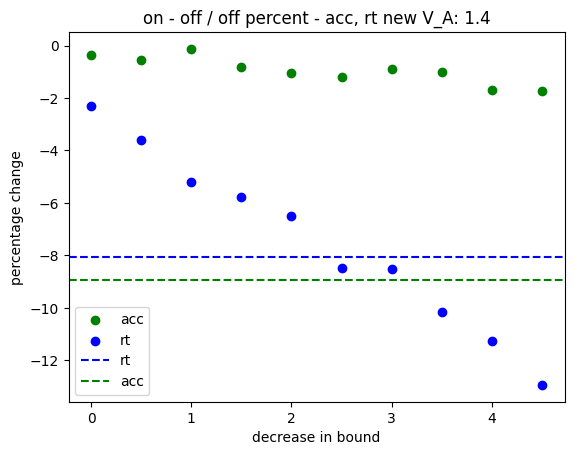

In [7]:
mean_vs_param_on_acc = np.zeros((N_params))
mean_vs_param_off_acc = np.zeros((N_params))


mean_vs_param_on_rt = np.zeros((N_params))
mean_vs_param_off_rt = np.zeros((N_params))



for i in range(N_params):
    results =  bound_change_results_dict[i]['results']
    
    on_total = 0
    on_correct = 0

    off_total = 0
    off_correct = 0

    for res in results:
        if res['is_LED_trial'] and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            on_total += 1
            if (res['ILD'] > 0 and res['choice'] == 1) or (res['ILD'] < 0 and res['choice'] == -1):
                on_correct += 1

        elif (not res['is_LED_trial']) and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            off_total += 1
            if (res['ILD'] > 0 and res['choice'] == 1) or (res['ILD'] < 0 and res['choice'] == -1):
                off_correct += 1

    mean_vs_param_on_acc[i] = on_correct / on_total
    mean_vs_param_off_acc[i] = off_correct / off_total





for i in range(N_params):
    results =  bound_change_results_dict[i]['results']

    on_rt = []
    off_rt = []

    for res in results:
        if res['is_LED_trial'] and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            on_rt.append(res['rt'] - res['t_stim'])
        elif (not res['is_LED_trial']) and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            off_rt.append(res['rt'] - res['t_stim'])

    mean_vs_param_on_rt[i] = np.mean(on_rt)
    mean_vs_param_off_rt[i] = np.mean(off_rt)

plt.scatter([i * bound_step_size for i in range(N_params)], 100*(mean_vs_param_on_acc - mean_vs_param_off_acc)/mean_vs_param_off_acc, label='acc', color='g')
plt.scatter([i * bound_step_size for i in range(N_params)], 100*(mean_vs_param_on_rt - mean_vs_param_off_rt)/mean_vs_param_off_rt, label='rt', color='b')

plt.axhline(-8.0781, label='rt', color='b', linestyle='--')
plt.axhline(-8.9482, label='acc', color='g', linestyle='--')

plt.xlabel('decrease in bound')
plt.ylabel('percentage change')
plt.legend()
plt.title(f'on - off / off percent - acc, rt new V_A: {new_V_A}');


# metric 1 - % of aborts

In [8]:
for i in range(N_params):
    new_bound = bound_change_results_dict[i]['new_bound']
    new_V_A = bound_change_results_dict[i]['new_V_A']
    sim_results = bound_change_results_dict[i]['results']

    sim_results_led_on = [res for res in sim_results if res['is_LED_trial'] == 1]
    sim_results_led_off = [res for res in sim_results if res['is_LED_trial'] == 0]

    aborts_led_on = [res for res in sim_results_led_on if res['rt'] < res['t_stim'] and res['rt'] > res['t_led']]
    aborts_led_off = [res for res in sim_results_led_off if res['rt'] < res['t_stim'] and res['rt'] > res['t_led']]

    print(f'new bound: {new_bound}, new V_A: {new_V_A}')
    frac_of_aborts_led_on = len(aborts_led_on) / len(sim_results_led_on)
    frac_of_aborts_led_off = len(aborts_led_off) / len(sim_results_led_off)

    increase_in_aborts_relative_to_off = 100*(frac_of_aborts_led_on - frac_of_aborts_led_off) / frac_of_aborts_led_off
    print(f'led on frac= {100*frac_of_aborts_led_on:.2f}, led off frac = {100*frac_of_aborts_led_off:.2f},% aborts change = {increase_in_aborts_relative_to_off:.2f}%')



new bound: 40.5, new V_A: 1.4
led on frac= 13.83, led off frac = 10.62,% aborts change = 30.26%
new bound: 40.0, new V_A: 1.4
led on frac= 13.61, led off frac = 11.08,% aborts change = 22.91%
new bound: 39.5, new V_A: 1.4
led on frac= 13.85, led off frac = 11.08,% aborts change = 25.01%
new bound: 39.0, new V_A: 1.4
led on frac= 13.74, led off frac = 10.98,% aborts change = 25.11%
new bound: 38.5, new V_A: 1.4
led on frac= 13.79, led off frac = 11.06,% aborts change = 24.64%
new bound: 38.0, new V_A: 1.4
led on frac= 13.65, led off frac = 10.97,% aborts change = 24.42%
new bound: 37.5, new V_A: 1.4
led on frac= 13.29, led off frac = 10.85,% aborts change = 22.45%
new bound: 37.0, new V_A: 1.4
led on frac= 13.32, led off frac = 10.70,% aborts change = 24.47%
new bound: 36.5, new V_A: 1.4
led on frac= 13.90, led off frac = 10.94,% aborts change = 27.07%
new bound: 36.0, new V_A: 1.4
led on frac= 13.83, led off frac = 10.91,% aborts change = 26.71%


# metric - 2 - psycho

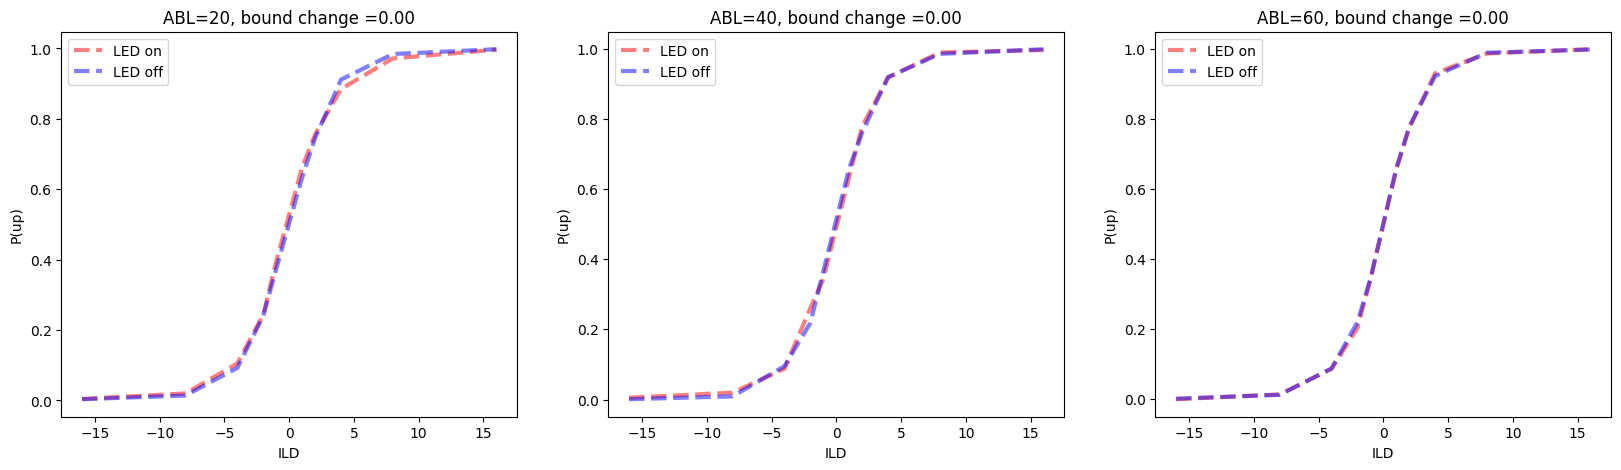

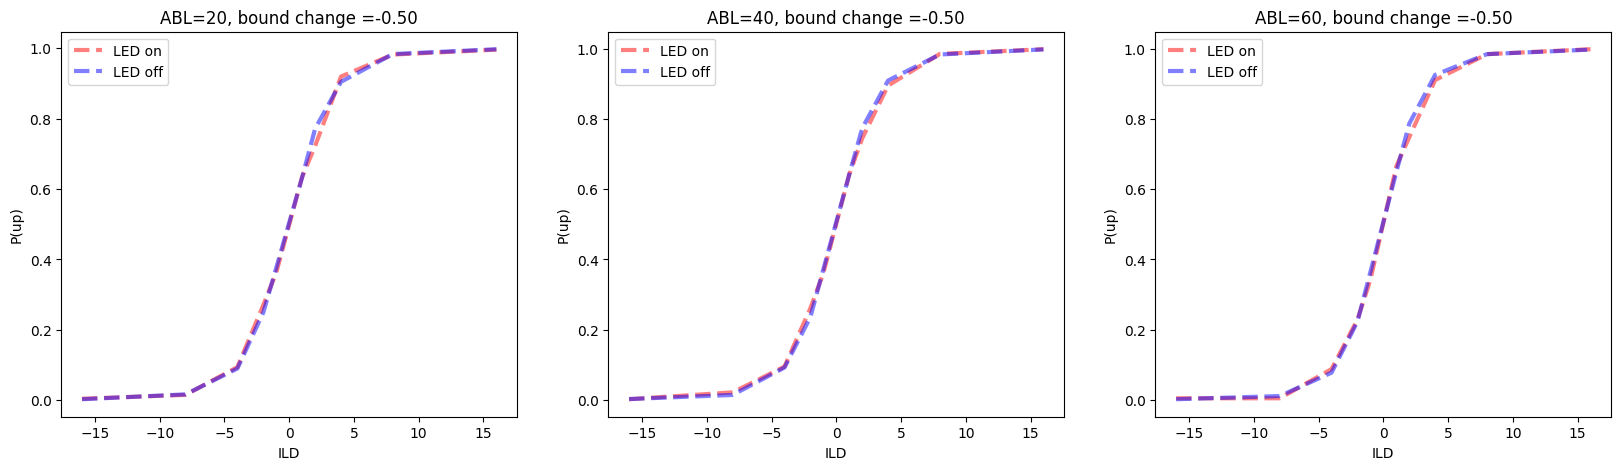

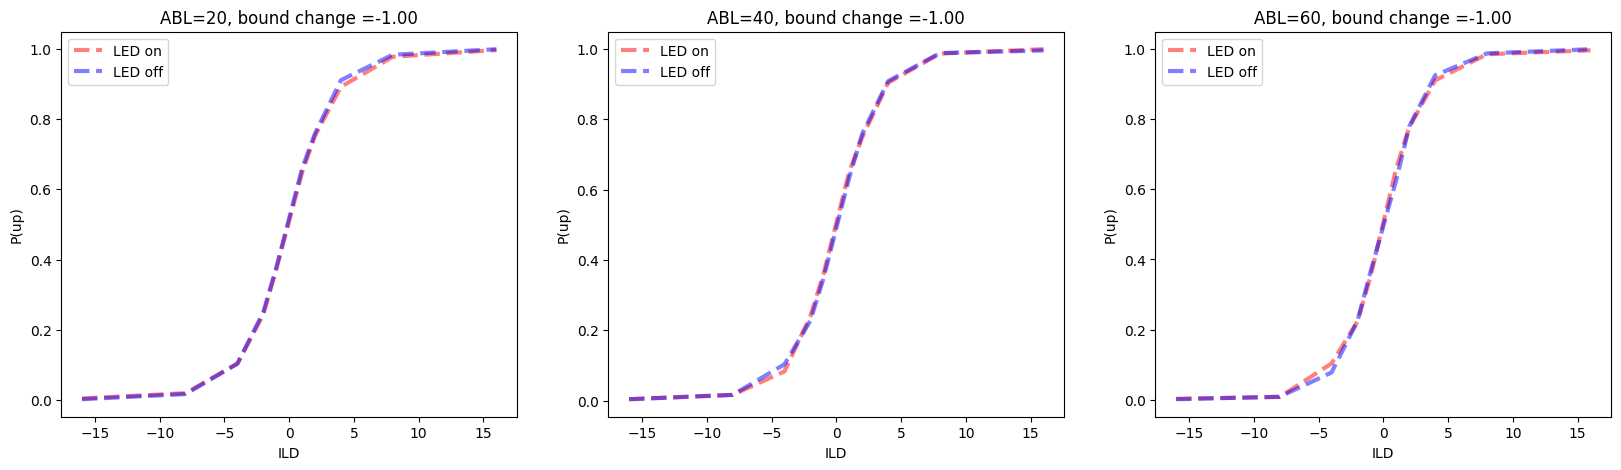

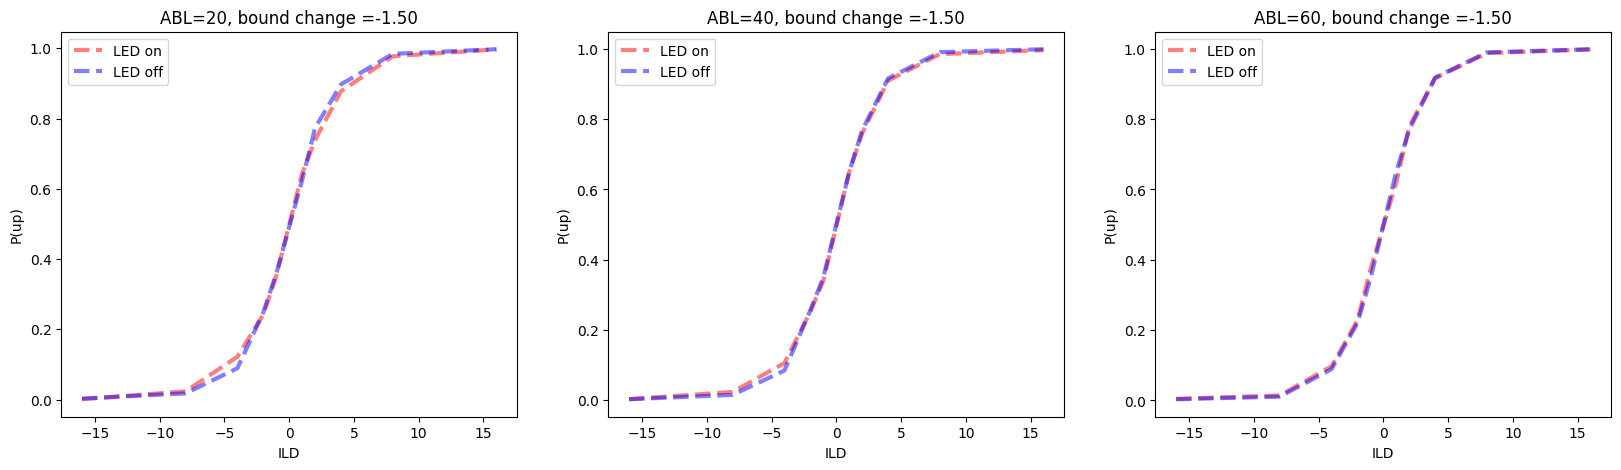

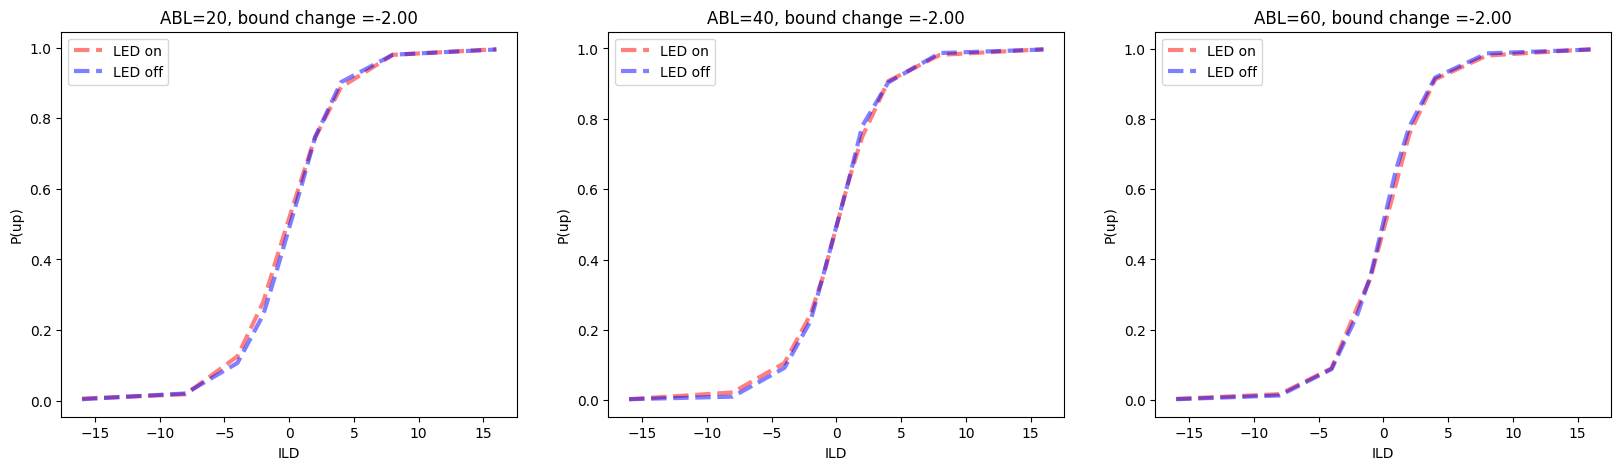

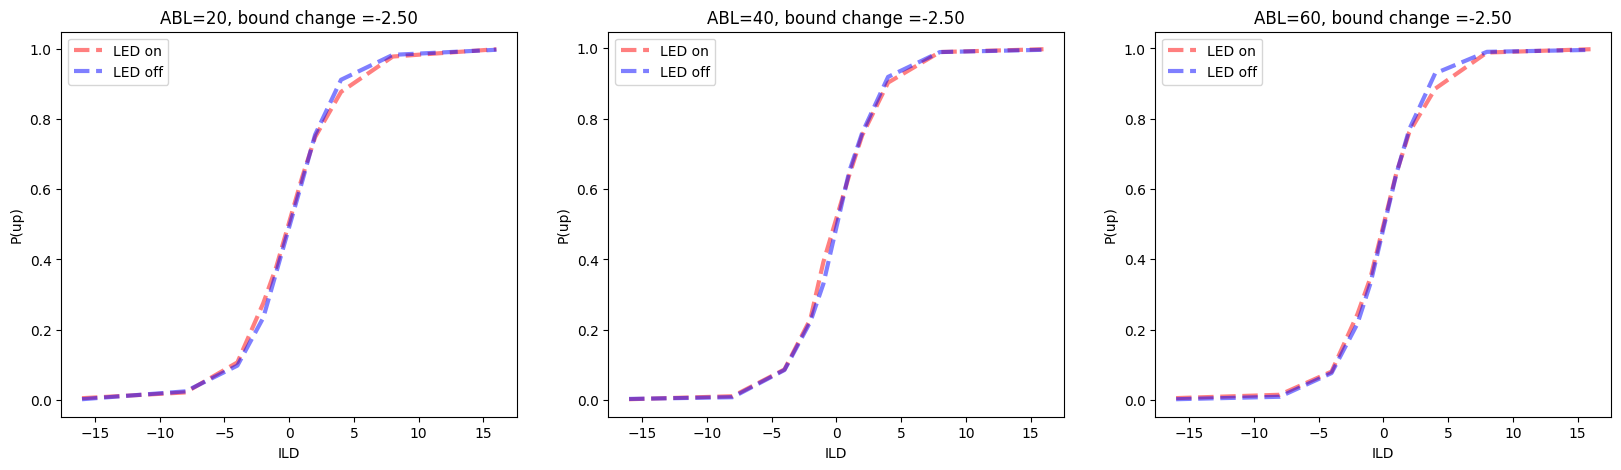

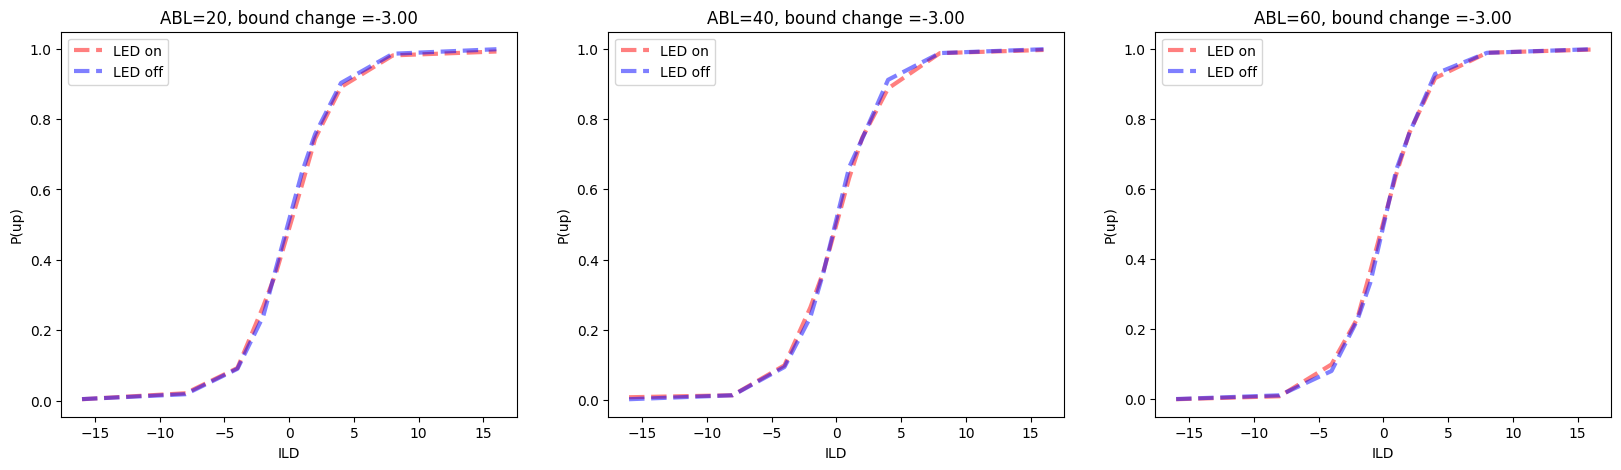

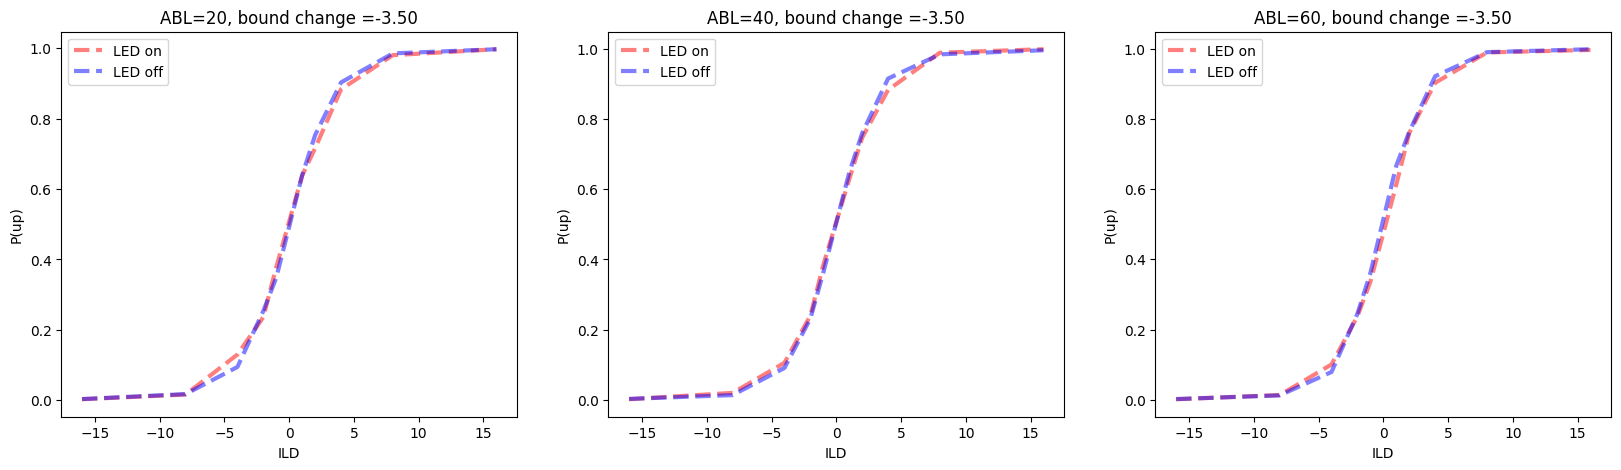

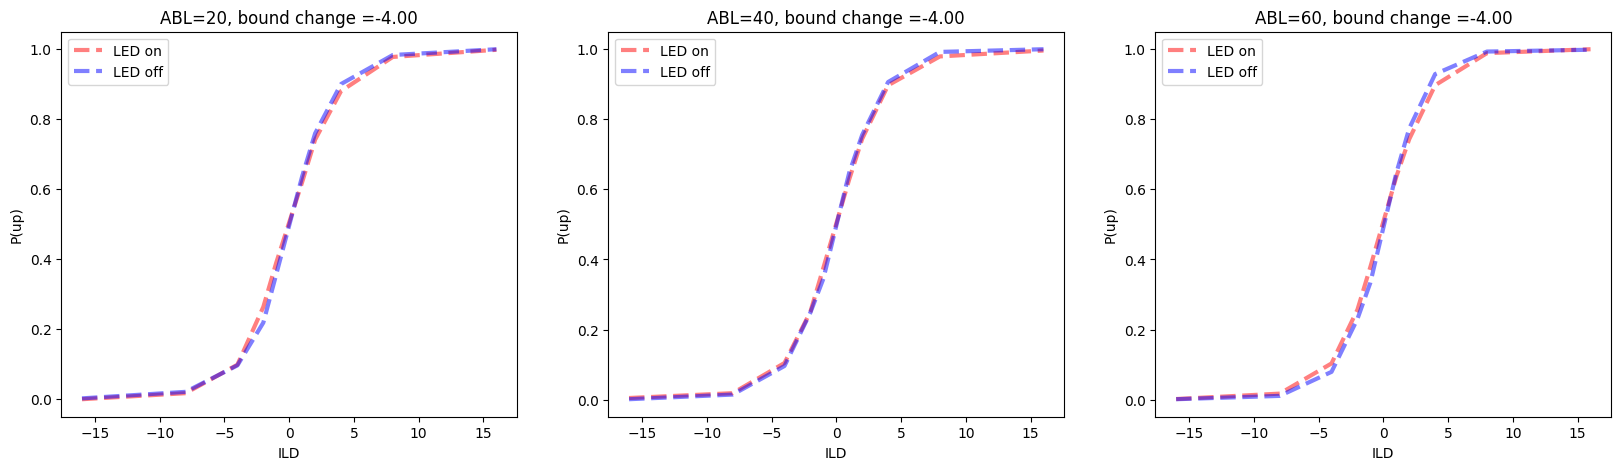

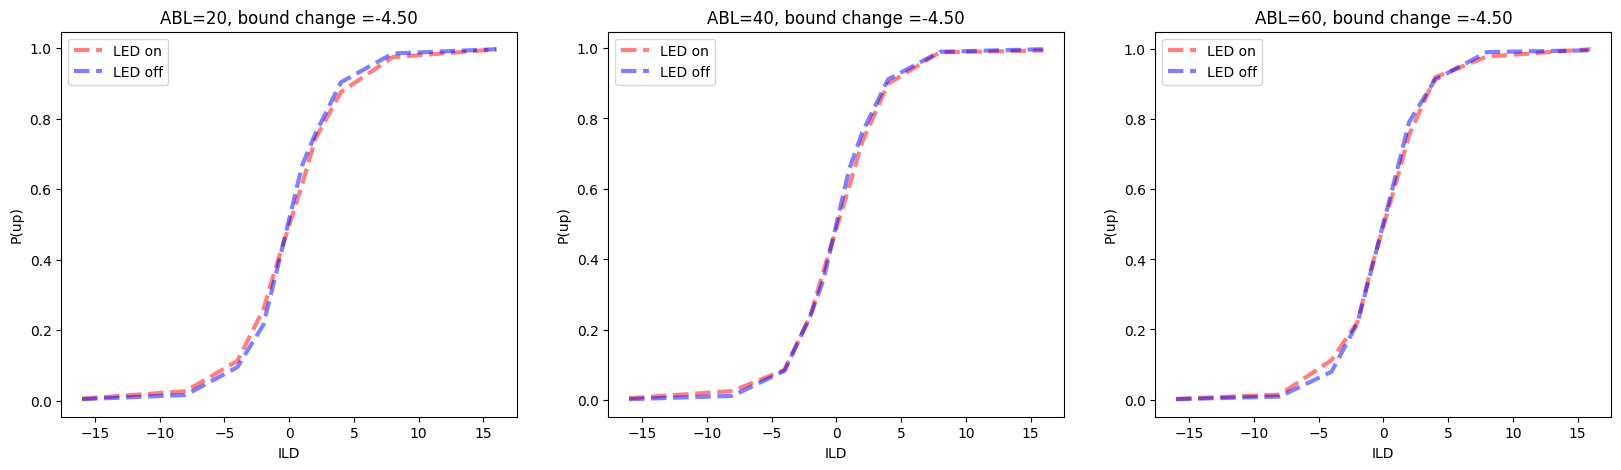

In [9]:
for i in range(0, N_params):
    # for each V_A
    each_bound_results = bound_change_results_dict[i]['results']
    new_bound = bound_change_results_dict[i]['new_bound']

    num_up_on = {}; num_trials_on = {}
    num_up_off = {}; num_trials_off = {}
    for ABL in ABL_arr:
        num_up_on[ABL] = np.zeros_like(ILD_arr)
        num_trials_on[ABL] = np.zeros_like(ILD_arr)

        num_up_off[ABL] = np.zeros_like(ILD_arr)
        num_trials_off[ABL] = np.zeros_like(ILD_arr)

    
    for res in each_bound_results:
        ABL = res['ABL']
        ILD = res['ILD']
        is_LED_trial = res['is_LED_trial']
        if is_LED_trial:
            if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
                num_trials_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
                if res['choice'] == 1:
                    num_up_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
        elif not is_LED_trial:
            if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
                num_trials_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
                if res['choice'] == 1:
                    num_up_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1

        

        

    plt.figure(figsize=(20,5))
    for a, ABL in enumerate(ABL_arr):
        plt.subplot(1, len(ABL_arr), a+1)
        plt.title(f'ABL={ABL}, bound change ={new_bound - theta_E:.2f}')

        
        plt.plot(ILD_arr, num_up_on[ABL]/num_trials_on[ABL], label='LED on', linestyle='--', color='r', lw=3, alpha=0.5)
        plt.plot(ILD_arr, num_up_off[ABL]/num_trials_off[ABL], label='LED off', linestyle='--', color='b', lw=3, alpha=0.5)
        
        plt.legend()
        plt.xlabel('ILD'); plt.ylabel('P(up)');

## psychometric - designed

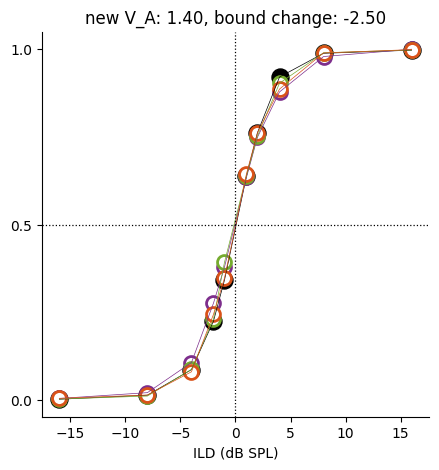

In [12]:
i = 5
each_bound_data = bound_change_results_dict[i]['results']
new_V_A = bound_change_results_dict[i]['new_V_A']
new_bound = bound_change_results_dict[i]['new_bound']

num_up_on = {}; num_trials_on = {}
num_up_off = {}; num_trials_off = {}
for ABL in ABL_arr:
    num_up_on[ABL] = np.zeros_like(ILD_arr)
    num_trials_on[ABL] = np.zeros_like(ILD_arr)

    num_up_off[ABL] = np.zeros_like(ILD_arr)
    num_trials_off[ABL] = np.zeros_like(ILD_arr)


for res in each_bound_data:
    ABL = res['ABL']
    ILD = res['ILD']
    is_LED_trial = res['is_LED_trial']
    if is_LED_trial:
        if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
            num_trials_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
            if res['choice'] == 1:
                num_up_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
    elif not is_LED_trial:
        if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
            num_trials_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
            if res['choice'] == 1:
                num_up_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1

    


# average all LED off
led_off_psycho = np.zeros((len(ABL_arr), len(ILD_arr)))
for a, ABL in enumerate(ABL_arr):
    led_off_psycho[a] = num_up_off[ABL]/num_trials_off[ABL]
  

# take average of led_off_psycho across first dimension
led_off_psycho_avg = np.mean(led_off_psycho, axis=0)
plt.figure(figsize=(5,5))
# off
plt.scatter(ILD_arr, led_off_psycho_avg, color='k', marker='o', s=150)
plt.plot(ILD_arr, led_off_psycho_avg, color='k', lw=0.5)

# on
ABL_color_codes = {ABL_arr[0]: '#7D2E8C', ABL_arr[1]: '#75AB2E', ABL_arr[2]: '#D95219'}
for a,ABL in enumerate(ABL_arr):
    plt.scatter(ILD_arr, num_up_on[ABL]/num_trials_on[ABL], label=f'{ABL}', edgecolor=ABL_color_codes[ABL], marker='o', s=100, facecolors='white', lw=2)
    plt.plot(ILD_arr, num_up_on[ABL]/num_trials_on[ABL], color=ABL_color_codes[ABL], lw=0.5)

plt.axhline(0.5, color='k', linestyle='dotted', lw=0.9)
plt.axvline(0, color='k', linestyle='dotted',lw=0.9)
plt.yticks([0, 0.5, 1])
plt.xlabel('ILD (dB SPL)')
plt.title(f'new V_A: {new_V_A:.2f}, bound change: {new_bound - theta_E:.2f}')

ax = plt.gca()  # Get the current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()



# plot all led off
# for a,ABL in enumerate(ABL_arr):
#     plt.plot(ILD_arr, led_off_psycho[a], label='LED off', linestyle='--', color='b', lw=3, alpha=0.5)
# plt.figure(figsize=(20,5))
# for a, ABL in enumerate(ABL_arr):
#     plt.subplot(1, len(ABL_arr), a+1)
#     plt.title(f'ABL={ABL},V_A={base_V_A}, new_V_A={new_V_A:.2f}')

    
#     plt.plot(ILD_arr, num_up_on[ABL]/num_trials_on[ABL], label='LED on', linestyle='--', color='r', lw=3, alpha=0.5)
#     plt.plot(ILD_arr, num_up_off[ABL]/num_trials_off[ABL], label='LED off', linestyle='--', color='b', lw=3, alpha=0.5)
    
#     plt.legend()
#     plt.xlabel('ILD'); plt.ylabel('P(up)');




# chronometric w./o aborts

## real dataa

In [10]:
df_1 = df [ df['LED_trial'] == 1 ]
df_0 = df [ df['LED_trial'] == 0 ]

led_on_abl_ild = {}
led_off_abl_ild = {}

positive_ILD_arr = ILD_arr[ILD_arr > 0]

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        led_on_abl_ild[(ABL, ILD)] = []
        led_off_abl_ild[(ABL, ILD)] = []

# ON
for _, row in df_1.iterrows():
    ABL = row['ABL']
    ILD = row['ILD']
    abs_ILD = np.abs(ILD)

    if row['timed_fix'] > row['LED_onset_time'] and row['timed_fix'] > row['intended_fix']: # if after onset time
        led_on_abl_ild[(ABL, abs_ILD)].append(row['timed_fix'] - row['intended_fix'])
    
# OFF
for _, row in df_0.iterrows():
    ABL = row['ABL']
    ILD = row['ILD']
    abs_ILD = np.abs(ILD)

    if row['timed_fix'] > row['LED_onset_time'] and row['timed_fix'] > row['intended_fix']: # if after onset time
        led_off_abl_ild[(ABL, abs_ILD)].append(row['timed_fix'] - row['intended_fix'])


# on and off mean and std
led_on_mean = {}
led_on_std_err = {}

led_off_mean = {}
led_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        led_on_mean[(ABL, ILD)] = np.mean(led_on_abl_ild[(ABL, ILD)])
        led_on_std_err[(ABL, ILD)] = np.std(led_on_abl_ild[(ABL, ILD)])/np.sqrt(len(led_on_abl_ild[(ABL, ILD)]))

        led_off_mean[(ABL, ILD)] = np.mean(led_off_abl_ild[(ABL, ILD)])
        led_off_std_err[(ABL, ILD)] = np.std(led_off_abl_ild[(ABL, ILD)])/np.sqrt(len(led_off_abl_ild[(ABL, ILD)]))

## sim data

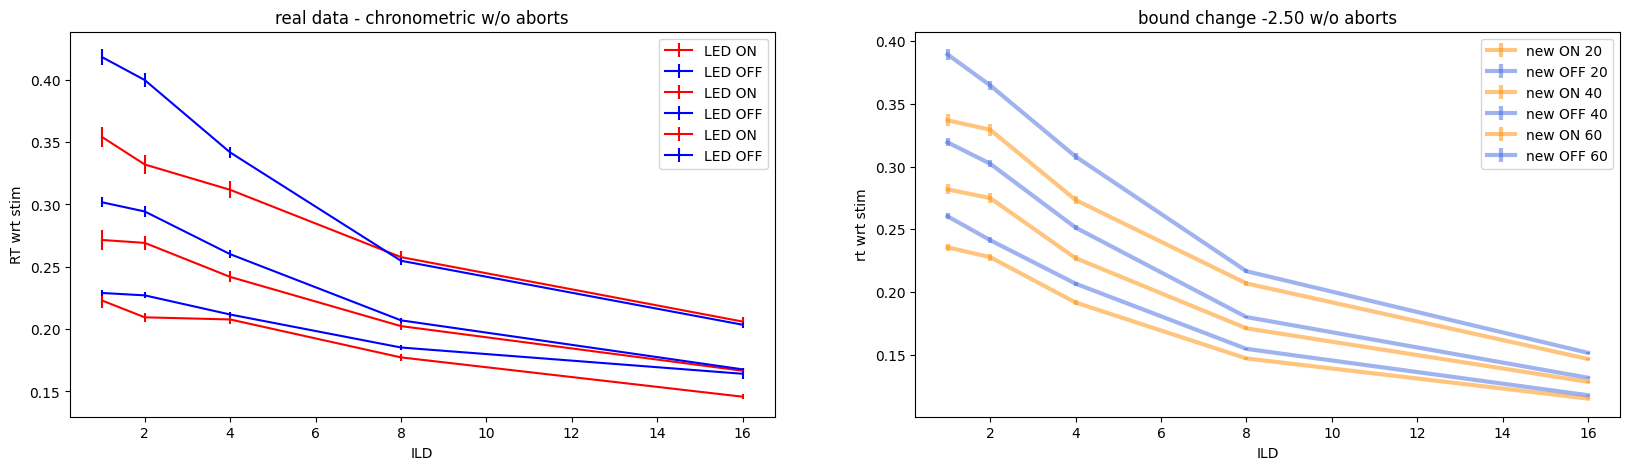

In [11]:
base_bound_data = bound_change_results_dict[0]['results']


# change V_A
new_bound_idx = 5
new_bound_value = bound_change_results_dict[new_bound_idx]['new_bound']
new_bound_data = bound_change_results_dict[new_bound_idx]['results']

# base and new init- collect rt
base_rt_abl_ild_on = {}
base_rt_abl_ild_off = {}

new_rt_abl_ild_on = {}
new_rt_abl_ild_off = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        base_rt_abl_ild_on[(ABL, ILD)] = []
        base_rt_abl_ild_off[(ABL, ILD)] = []

        new_rt_abl_ild_on[(ABL, ILD)] = []
        new_rt_abl_ild_off[(ABL, ILD)] = []

#  base
for res in base_bound_data:
    ABL = res['ABL']
    ILD = res['ILD']
    abs_ILD = np.abs(ILD)

    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            base_rt_abl_ild_on[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])
    elif not res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            base_rt_abl_ild_off[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])

# new
for res in new_bound_data:
    ABL = res['ABL']
    ILD = res['ILD']
    abs_ILD = np.abs(ILD)

    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            new_rt_abl_ild_on[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])
    elif not res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            new_rt_abl_ild_off[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])


# base
base_on_mean = {}
base_on_std_err = {}

base_off_mean = {}
base_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        base_on_mean[(ABL, ILD)] = np.mean(base_rt_abl_ild_on[(ABL, ILD)])
        base_on_std_err[(ABL, ILD)] = np.std(base_rt_abl_ild_on[(ABL, ILD)]) / np.sqrt(len(base_rt_abl_ild_on[(ABL, ILD)]))

        base_off_mean[(ABL, ILD)] = np.mean(base_rt_abl_ild_off[(ABL, ILD)])
        base_off_std_err[(ABL, ILD)] = np.std(base_rt_abl_ild_off[(ABL, ILD)]) / np.sqrt(len(base_rt_abl_ild_off[(ABL, ILD)]))

# new
new_on_mean = {}
new_on_std_err = {}

new_off_mean = {}
new_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        new_on_mean[(ABL, ILD)] = np.mean(new_rt_abl_ild_on[(ABL, ILD)])
        new_on_std_err[(ABL, ILD)] = np.std(new_rt_abl_ild_on[(ABL, ILD)]) / np.sqrt(len(new_rt_abl_ild_on[(ABL, ILD)]))

        new_off_mean[(ABL, ILD)] = np.mean(new_rt_abl_ild_off[(ABL, ILD)])
        new_off_std_err[(ABL, ILD)] = np.std(new_rt_abl_ild_off[(ABL, ILD)]) / np.sqrt(len(new_rt_abl_ild_off[(ABL, ILD)]))

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
for ABL in ABL_arr:
    # mean and err vs positive ILD
    plt.errorbar(positive_ILD_arr, [led_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[led_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label='LED ON', color='red')
    plt.errorbar(positive_ILD_arr, [led_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[led_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label='LED OFF', color='blue')

    plt.xlabel('ILD')
    plt.ylabel('RT wrt stim')
    plt.legend()
    plt.title('real data - chronometric w/o aborts')

plt.subplot(1,2,2)
for ABL in ABL_arr:
    plt.errorbar(positive_ILD_arr, [new_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new ON {ABL}', color='darkorange', lw=3, alpha=0.5)
    plt.errorbar(positive_ILD_arr, [new_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new OFF {ABL}', color='royalblue', lw=3, alpha=0.5)
    plt.legend()
    plt.xlabel('ILD'); plt.ylabel('rt wrt stim')
    plt.title(f'bound change {(new_bound_value - theta_E):.2f} w/o aborts')

## chronometric designed

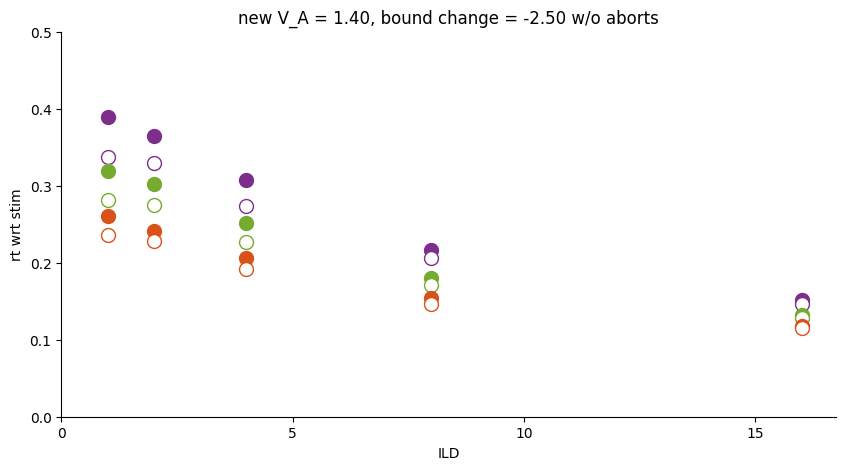

In [14]:
ABL_color_codes = {ABL_arr[0]: '#7D2E8C', ABL_arr[1]: '#75AB2E', ABL_arr[2]: '#D95219'}

plt.figure(figsize=(10,5))
for ABL in ABL_arr:
    # off filled
    # plt.errorbar(positive_ILD_arr, [new_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new OFF {ABL}', color=ABL_color_codes[ABL], lw=3, alpha=0.5)
    plt.scatter(
    positive_ILD_arr, 
    [new_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], 
    label=f'new OFF {ABL}', 
    color=ABL_color_codes[ABL],  # Marker fill color
    marker='o', 
    s=100  # Adjust size as needed
)
    # plt.errorbar(
    #     positive_ILD_arr, 
    #     [new_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], 
    #     yerr=[new_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], 
    #     fmt='none',  # No markers for error bars
    #     color=ABL_color_codes[ABL],  # Same color as the scatter markers
    #     lw=1,  # Line width for error bars
    #     capsize=3
    # )
    # ON plain
    # plt.errorbar(positive_ILD_arr, [new_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new ON {ABL}', color=ABL_color_codes[ABL])
    # Scatter plot with white fill color and colored edges
    # Error bars
    # plt.errorbar(
    #     positive_ILD_arr, 
    #     [new_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], 
    #     yerr=[new_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], 
    #     fmt='none',  # No markers for error bars
    #     color=ABL_color_codes[ABL],  # Color of the error bars (matches edge color)
    #     lw=1,
    #     capsize=3
    # )
    plt.scatter(
        positive_ILD_arr, 
        [new_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], 
        label=f'new ON {ABL}', 
        facecolor='white',  # White fill color
        edgecolor=ABL_color_codes[ABL],  # Edge color
        marker='o', 
        s=100,  # Adjust marker size as needed
        linewidths=1  # Thickness of the edge
    )

    

    # plt.legend()
    plt.xlabel('ILD'); plt.ylabel('rt wrt stim')
    plt.title(f'new V_A = {new_V_A:.2f}, bound change = {new_bound_value - theta_E:.2f} w/o aborts')
    plt.xticks([0, 5, 10, 15])
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])

ax = plt.gca()  # Get the current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()